<a href="https://colab.research.google.com/github/florentiino/monet_boys/blob/master/SimpleWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monet model test

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports + Define generator

In [51]:
!pip install tensorflow_addons
!pip install mpimg

In [52]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import PIL
import mpimg

In [53]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [54]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Import Cycle GAN trained model

In [55]:
monet_path = '/content/drive/MyDrive/Colab Notebooks/Monet_B/painter_weights/monet_weights.h5'
cezanne_path = '/content/drive/MyDrive/Colab Notebooks/Monet_B/painter_weights/cezanne_weights.h5'
vangogh_path = '/content/drive/MyDrive/Colab Notebooks/Monet_B/painter_weights/vangogh_weights.h5'
ukiyoe_path = '/content/drive/MyDrive/Colab Notebooks/Monet_B/painter_weights/ukiyoe_weights.h5'

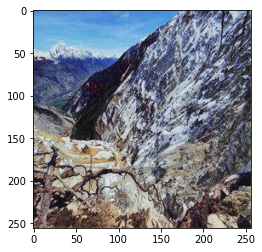

In [56]:
monet_generator = Generator()
monet_generator.load_weights(vangogh_path)

vangogh_prediction = monet_generator(imagetensor, training=False)[0].numpy()
vangogh_prediction = (vangogh_prediction * 127.5 + 127.5).astype(np.uint8)

plt.imshow(vangogh_prediction)

In [57]:
monet_generator = Generator()
cezanne_generator = Generator()
vangogh_generator = Generator()
ukiyoe_generator = Generator()

In [58]:
monet_generator.load_weights(cezanne_path)
cezanne_generator.load_weights(cezanne_path)
vangogh_generator.load_weights(vangogh_path)
ukiyoe_generator.load_weights(ukiyoe_path)


## Load a photo

In [59]:
IMAGE_SIZE = [256, 256]

image_path = '/content/drive/MyDrive/Colab Notebooks/Monet_B/20210508_122723 (1).jpg'

image = PIL.Image.open(image_path)
print(image.size)

resized_image = image.resize((256,256))
print(resized_image.size)

new_image_path = image_path.replace('.', '_new.')

resized_image.save(new_image_path)

(256, 256)
(256, 256)


In [60]:


#input_image= mpimg.imread(image_path)

input_tensor = tf.io.read_file(new_image_path)

imagetensor = tf.image.decode_jpeg(input_tensor, channels=3)
imagetensor = (tf.cast(imagetensor, tf.float32) / 127.5) - 1

imagetensor = tf.reshape(imagetensor, [*IMAGE_SIZE, 3])
imagetensor = tf.expand_dims(imagetensor, axis=0)

## Perform a transormation

In [61]:
monet_prediction = monet_generator(imagetensor, training=False)[0].numpy()
monet_prediction = (monet_prediction * 127.5 + 127.5).astype(np.uint8)

cezanne_prediction = cezanne_generator(imagetensor, training=False)[0].numpy()
cezanne_prediction = (cezanne_prediction * 127.5 + 127.5).astype(np.uint8)

vangogh_prediction = vangogh_generator(imagetensor, training=False)[0].numpy()
vangogh_prediction = (vangogh_prediction * 127.5 + 127.5).astype(np.uint8)

ukiyoe_prediction = ukiyoe_generator(imagetensor, training=False)[0].numpy()
ukiyoe_prediction = (ukiyoe_prediction * 127.5 + 127.5).astype(np.uint8)



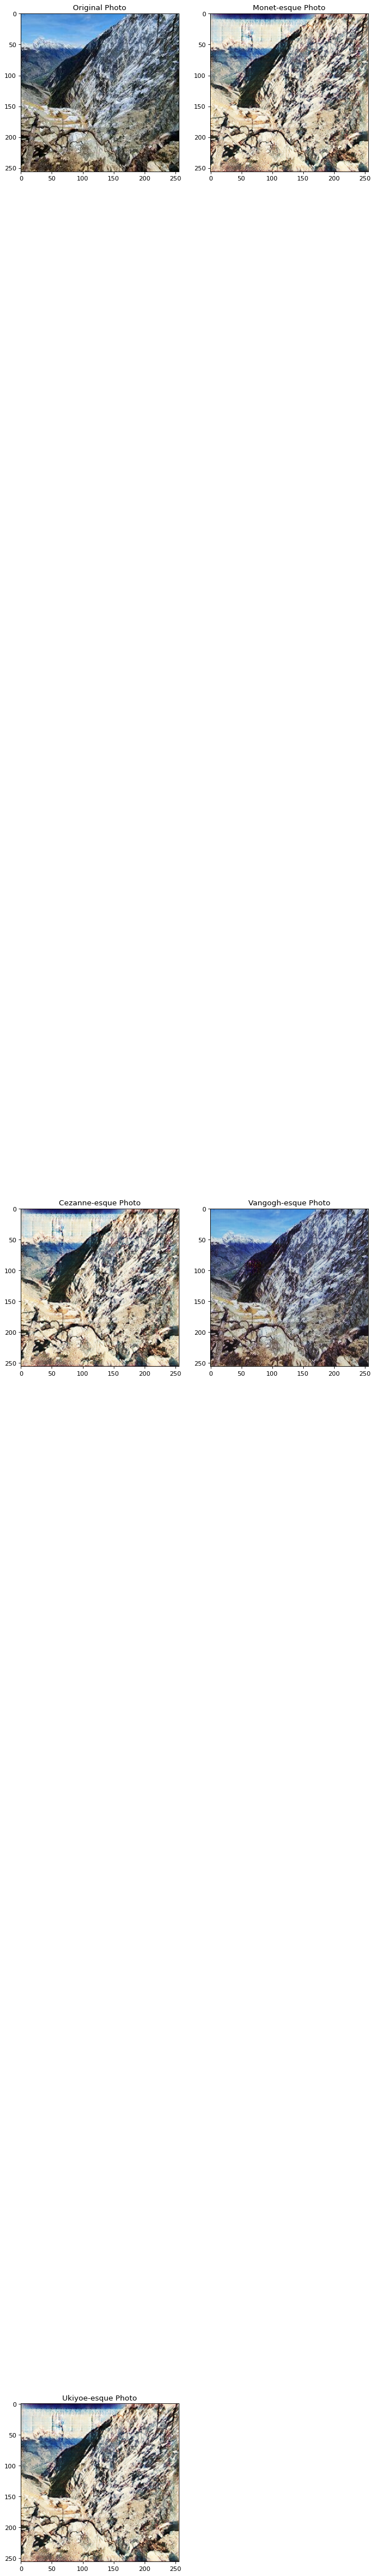

In [62]:
plt.figure(figsize=(10,30), dpi=80)

plt.subplot(321)
plt.title("Original Photo")
plt.imshow(imagetensor[0] * 0.5 + 0.5)

plt.subplot(322)
plt.title("Monet-esque Photo")
plt.imshow(monet_prediction)

plt.subplot(323)
plt.title("Cezanne-esque Photo")
plt.imshow(cezanne_prediction)

plt.subplot(324)
plt.title("Vangogh-esque Photo")
plt.imshow(vangogh_prediction)

plt.subplot(325)
plt.title("Ukiyoe-esque Photo")
plt.imshow(ukiyoe_prediction)
plt.show()

In [63]:
im = PIL.Image.fromarray(monet_prediction)
im.save("/content/drive/MyDrive/Colab Notebooks/Monet_B/images/" + 'monet_' + ".jpg")

im = PIL.Image.fromarray(cezanne_prediction)
im.save("/content/drive/MyDrive/Colab Notebooks/Monet_B/images/" + 'cezanne_' + ".jpg")

im = PIL.Image.fromarray(vangogh_prediction)
im.save("/content/drive/MyDrive/Colab Notebooks/Monet_B/images/" + 'vangogh_' + ".jpg")

im = PIL.Image.fromarray(ukiyoe_prediction)
im.save("/content/drive/MyDrive/Colab Notebooks/Monet_B/images/" + 'ukiyoe_' + ".jpg")


In [64]:
prediction = monet_generator(imagetensor, training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

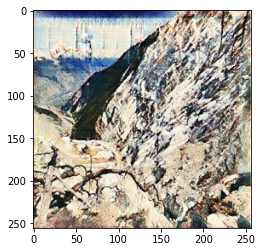

In [65]:
plt.imshow(monet_prediction)

In [66]:
to_monet = monet_gen_2(imagetensor)

plt.figure(figsize=(15, 10), dpi=80)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(imagetensor[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()



NameError: ignored

In [ ]:


prediction = to_monet[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
im = PIL.Image.fromarray(prediction)
im.save("/content/drive/MyDrive/Colab Notebooks/Monet_B/" + 'MONEEEET' + ".jpg")

In [ ]:
type(monet_generator)